# Sistema PSO para Otimização de Hiperparâmetros - Classificação de Parkinson

Este notebook implementa um sistema modular para otimização de hiperparâmetros de uma rede neural feedforward usando Particle Swarm Optimization (PSO) para classificação binária de Parkinson.

## Características do Sistema:
- 32 experimentos independentes
- Armazenamento completo em SQLite
- Monitoramento de recursos (CPU, memória, disco)
- Barras de progresso com tqdm.notebook
- Avaliação final com validação cruzada estratificada

## Estrutura do Projeto:
- `config.py`: Configurações centralizadas
- `data_utils.py`: Carregamento e preparação dos dados
- `model_utils.py`: Construção e treino da rede neural
- `database_utils.py`: Criação e manipulação do SQLite
- `pso_optimizer.py`: Execução do PSO com registro completo
- `evaluate_final_model.py`: Avaliação do melhor modelo

## 1. Importações e Configuração Inicial

In [ ]:
# pip install numpy pandas tensorflow scikit-learn matplotlib seaborn tqdm psutil

In [1]:
# Importações principais
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

# Configurar warnings
warnings.filterwarnings('ignore')

# Configurar matplotlib
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

# Importar módulos do projeto
import config
import data_utils
import model_utils
import database_utils
import pso_optimizer
import evaluate_final_model

print("✅ Importações realizadas com sucesso!")
print(f"📊 Configuração PSO: {config.PSO_CONFIG['n_particles']} partículas, {config.PSO_CONFIG['iters']} iterações, {config.PSO_CONFIG['experimentos']} experimentos")

✅ Importações realizadas com sucesso!
📊 Configuração PSO: 20 partículas, 20 iterações, 2 experimentos


## 2. Exploração dos Dados

In [2]:
# Carregar e explorar dados
print("📊 Carregando dataset de Parkinson...")
df = data_utils.load_parkinson_data()

# Validar dados
data_utils.validate_data(df)

# Informações do dataset
info = data_utils.get_data_info(df)
print(f"\n📈 Informações do Dataset:")
print(f"  • Amostras: {info['n_samples']}")
print(f"  • Features: {info['n_features']}")
print(f"  • Distribuição de classes: {info['target_distribution']}")
print(f"  • Valores ausentes: {info['missing_values']}")

# Mostrar primeiras linhas
display(df.head())

📊 Carregando dataset de Parkinson...

📈 Informações do Dataset:
  • Amostras: 195
  • Features: 22
  • Distribuição de classes: {1.0: 147, 0.0: 48}
  • Valores ausentes: 0


,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1.0,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1.0,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1.0,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1.0,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1.0,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


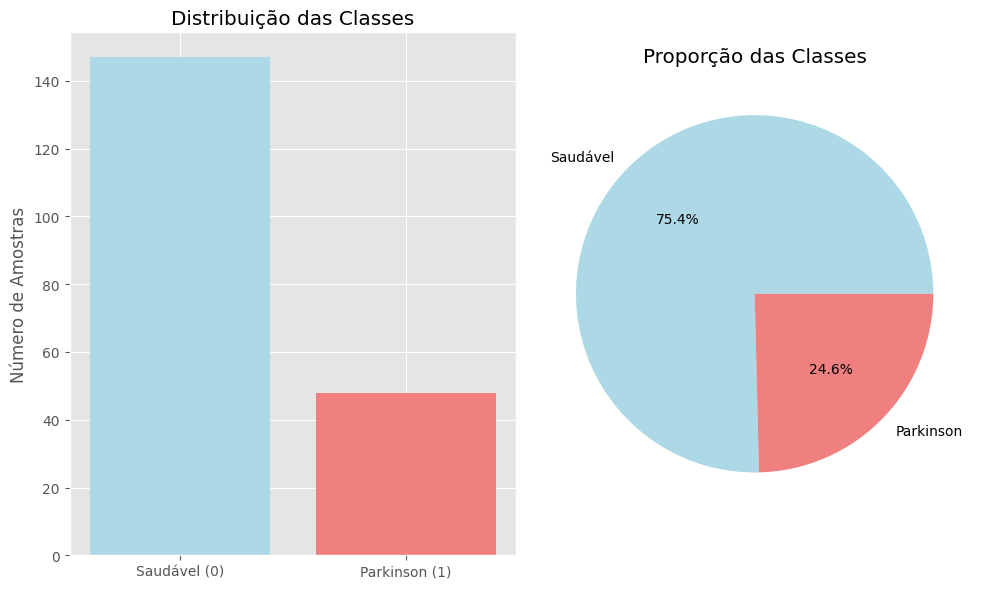

Dataset balanceado: Não


In [3]:
# Visualizar distribuição das classes
plt.figure(figsize=(10, 6))

# Gráfico de barras
plt.subplot(1, 2, 1)
class_counts = df['status'].value_counts()
plt.bar(['Saudável (0)', 'Parkinson (1)'], class_counts.values, color=['lightblue', 'lightcoral'])
plt.title('Distribuição das Classes')
plt.ylabel('Número de Amostras')

# Gráfico de pizza
plt.subplot(1, 2, 2)
plt.pie(class_counts.values, labels=['Saudável', 'Parkinson'], autopct='%1.1f%%', colors=['lightblue', 'lightcoral'])
plt.title('Proporção das Classes')

plt.tight_layout()
plt.show()

print(f"Dataset balanceado: {'Sim' if abs(class_counts[0] - class_counts[1]) / len(df) < 0.1 else 'Não'}")

## 3. Preparação dos Dados

In [ ]:
# Preparar dados para validação cruzada
print("🔄 Preparando dados para validação cruzada...")
X_data, y_data, scaler = data_utils.prepare_data_for_cv(df)

print(f"✅ Dados preparados:")
print(f"  • Shape X: {X_data.shape}")
print(f"  • Shape y: {y_data.shape}")
print(f"  • Tipo de normalização: MinMaxScaler")
print(f"  • Range dos dados: [{X_data.min():.3f}, {X_data.max():.3f}]")

## 4. Teste Rápido da Rede Neural

In [ ]:
print("🧪 Testando criação e treino da rede neural...")

# Parâmetros de teste
test_params = {
    'n_layers': 2,
    'neurons': [64, 32],
    'learning_rate': 0.001
}

from sklearn.model_selection import train_test_split
X_train_test, X_val_test, y_train_test, y_val_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=42, stratify=y_data
)

test_model = model_utils.create_neural_network(X_data.shape[1], test_params)
print(f"✅ Modelo criado com arquitetura: {test_params['neurons']}")

history = model_utils.train_neural_network(
    test_model, X_train_test, y_train_test, 
    X_val_test, y_val_test, epochs=10, verbose=1
)

# Salvar histórico de treino (loss) em CSV
import pandas as pd
history_df = pd.DataFrame({'loss': history.history['loss']})
history_df.to_csv('historico_loss_treino.csv', index=False)
print("📁 Histórico de loss salvo em 'historico_loss_treino.csv'")

metrics = model_utils.evaluate_model(test_model, X_val_test, y_val_test)
print(f"\n📊 Métricas do teste:")
print(f"  • F1-Score: {metrics['f1_score']:.4f}")
print(f"  • Accuracy: {metrics['accuracy']:.4f}")
print(f"  • AUC: {metrics['auc']:.4f}")

del test_model
import tensorflow as tf
tf.keras.backend.clear_session()

print("✅ Teste da rede neural concluído com sucesso!")


## 5. Execução da Otimização PSO

⚠️ **ATENÇÃO**: Esta etapa pode demorar várias horas para ser concluída (32 experimentos × 30 iterações × 20 partículas = 19.200 treinamentos de rede neural).

Para teste rápido, você pode reduzir os valores em `config.py`.

In [ ]:
# Verificar configurações antes de executar
print("⚙️ Configurações atuais do PSO:")
print(f"  • Experimentos: {config.PSO_CONFIG['experimentos']}")
print(f"  • Partículas por experimento: {config.PSO_CONFIG['n_particles']}")
print(f"  • Iterações por experimento: {config.PSO_CONFIG['iters']}")
print(f"  • Total de treinamentos: {config.PSO_CONFIG['experimentos'] * config.PSO_CONFIG['n_particles'] * config.PSO_CONFIG['iters']:,}")

# Estimar tempo
estimated_time_hours = (config.PSO_CONFIG['experimentos'] * config.PSO_CONFIG['n_particles'] * config.PSO_CONFIG['iters'] * 2) / 3600
print(f"  • Tempo estimado: ~{estimated_time_hours:.1f} horas")

print("\n💡 Para teste rápido, edite config.py e reduza os valores.")

In [ ]:
# Executar otimização PSO
print("🚀 Iniciando otimização PSO...")
print("📊 Progresso será mostrado com barras de progresso interativas.")
print("💾 Todos os dados serão salvos automaticamente no banco SQLite.")

# Executar otimização
pso_results = pso_optimizer.run_pso_optimization()

print("\n🎉 Otimização PSO concluída com sucesso!")
print(f"🏆 Melhor F1-Score encontrado: {pso_results['best_experiment']['best_f1_score']:.4f}")

## 6. Análise dos Resultados PSO

In [ ]:
# Obter estatísticas dos experimentos
stats = database_utils.get_experiment_statistics()

print("📊 Estatísticas dos Experimentos PSO:")
print(f"  • Total de experimentos: {int(stats.get('total_experiments', 0))}")
print(f"  • Total de partículas avaliadas: {int(stats.get('total_particles', 0)):,}")
print(f"  • F1-Score médio: {stats.get('avg_f1_score', 0):.4f}")
print(f"  • Melhor F1-Score: {stats.get('best_f1_score', 0):.4f}")
print(f"  • Pior F1-Score: {stats.get('worst_f1_score', 0):.4f}")
print(f"  • Desvio padrão F1: {stats.get('std_f1_score', 0):.4f}")
print(f"  • Tempo médio por experimento: {stats.get('avg_total_time', 0):.1f}s")
print(f"  • Uso médio de CPU: {stats.get('avg_cpu_usage', 0):.1f}%")
print(f"  • Uso máximo de memória: {stats.get('avg_max_memory', 0):.1f} MB")

In [ ]:
# Obter melhor partícula
best_particle = database_utils.get_best_particle_overall()

if best_particle:
    print("🏆 Melhor Partícula Encontrada:")
    print(f"  • Experimento: {best_particle['experiment']}")
    print(f"  • Iteração: {best_particle['iteration']}")
    print(f"  • Partícula: {best_particle['particle']}")
    print(f"  • F1-Score: {best_particle['f1_score']:.4f}")
    print(f"  • Número de camadas: {best_particle['num_layers']}")
    
    # Decodificar parâmetros
    best_params = model_utils.decode_particle_position(best_particle['position'])
    print(f"  • Arquitetura: {best_params['neurons'][:best_params['n_layers']]}")
    print(f"  • Learning Rate: {best_params['learning_rate']:.6f}")
else:
    print("❌ Nenhum resultado encontrado no banco de dados.")

In [ ]:
# Plotar convergência dos experimentos
convergence_data = database_utils.get_convergence_data()

if len(convergence_data) > 0:
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Convergência por experimento
    plt.subplot(2, 2, 1)
    for exp in convergence_data['num_experimento'].unique()[:10]:  # Mostrar apenas 10 experimentos
        exp_data = convergence_data[convergence_data['num_experimento'] == exp]
        plt.plot(exp_data['num_iteracao'], exp_data['best_f1_score'], alpha=0.7, label=f'Exp {exp}')
    plt.xlabel('Iteração')
    plt.ylabel('Melhor F1-Score')
    plt.title('Convergência por Experimento (10 primeiros)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    # Plot 2: Média de convergência
    plt.subplot(2, 2, 2)
    avg_convergence = convergence_data.groupby('num_iteracao').agg({
        'best_f1_score': ['mean', 'std'],
        'avg_f1_score': 'mean'
    }).reset_index()
    
    iterations = avg_convergence['num_iteracao']
    best_mean = avg_convergence[('best_f1_score', 'mean')]
    best_std = avg_convergence[('best_f1_score', 'std')]
    avg_mean = avg_convergence[('avg_f1_score', 'mean')]
    
    plt.plot(iterations, best_mean, 'b-', label='Melhor F1 (média)', linewidth=2)
    plt.fill_between(iterations, best_mean - best_std, best_mean + best_std, alpha=0.3, color='blue')
    plt.plot(iterations, avg_mean, 'r--', label='F1 médio', linewidth=2)
    plt.xlabel('Iteração')
    plt.ylabel('F1-Score')
    plt.title('Convergência Média (todos os experimentos)')
    plt.legend()
    plt.grid(True)
    
    # Plot 3: Distribuição dos melhores F1-scores
    plt.subplot(2, 2, 3)
    best_scores = convergence_data.groupby('num_experimento')['best_f1_score'].max()
    plt.hist(best_scores, bins=20, alpha=0.7, color='green', edgecolor='black')
    plt.axvline(best_scores.mean(), color='red', linestyle='--', label=f'Média: {best_scores.mean():.4f}')
    plt.xlabel('Melhor F1-Score por Experimento')
    plt.ylabel('Frequência')
    plt.title('Distribuição dos Melhores F1-Scores')
    plt.legend()
    plt.grid(True)
    
    # Plot 4: Boxplot dos F1-scores por iteração
    plt.subplot(2, 2, 4)
    iterations_sample = [0, 5, 10, 15, 20, 25, 29]  # Amostra de iterações
    data_for_box = []
    labels_for_box = []
    
    for it in iterations_sample:
        iter_data = convergence_data[convergence_data['num_iteracao'] == it]['best_f1_score']
        if len(iter_data) > 0:
            data_for_box.append(iter_data)
            labels_for_box.append(f'It {it}')
    
    if data_for_box:
        plt.boxplot(data_for_box, labels=labels_for_box)
        plt.ylabel('F1-Score')
        plt.title('Distribuição F1-Score por Iteração')
        plt.xticks(rotation=45)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print(f"📈 Análise de convergência:")
    print(f"  • Melhor F1-Score final: {best_scores.max():.4f}")
    print(f"  • F1-Score médio final: {best_scores.mean():.4f}")
    print(f"  • Desvio padrão: {best_scores.std():.4f}")
    print(f"  • Melhoria média: {(best_scores.mean() - avg_convergence[('avg_f1_score', 'mean')].iloc[0]):.4f}")
else:
    print("❌ Nenhum dado de convergência encontrado.")

## 7. Avaliação Final do Melhor Modelo

In [ ]:
# Executar avaliação final com validação cruzada
print("🔍 Iniciando avaliação final do melhor modelo...")
print("📊 Será executada validação cruzada estratificada com 5 folds.")

final_results = evaluate_final_model.evaluate_best_model()

print("\n✅ Avaliação final concluída!")

In [ ]:
# Mostrar resultados detalhados
cv_metrics = final_results['cv_metrics']
global_metrics = final_results['global_metrics']

print("🎯 RESULTADOS FINAIS DA VALIDAÇÃO CRUZADA:")
print("=" * 50)
print(f"F1-Score:  {cv_metrics['f1_mean']:.4f} ± {cv_metrics['f1_std']:.4f}")
print(f"Accuracy:  {cv_metrics['accuracy_mean']:.4f} ± {cv_metrics['accuracy_std']:.4f}")
print(f"AUC-ROC:   {cv_metrics['auc_mean']:.4f} ± {cv_metrics['auc_std']:.4f}")
print("=" * 50)

print(f"\n🎯 MÉTRICAS GLOBAIS:")
print(f"F1-Score:  {global_metrics['f1_score']:.4f}")
print(f"Accuracy:  {global_metrics['accuracy']:.4f}")
print(f"AUC-ROC:   {global_metrics['auc']:.4f}")

# Matriz de confusão
cm = global_metrics['confusion_matrix']
tn, fp, fn, tp = cm.ravel()
print(f"\n🔢 MATRIZ DE CONFUSÃO:")
print(f"Verdadeiros Negativos: {tn}")
print(f"Falsos Positivos: {fp}")
print(f"Falsos Negativos: {fn}")
print(f"Verdadeiros Positivos: {tp}")

# Métricas adicionais
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

print(f"\n📈 MÉTRICAS DETALHADAS:")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Especificidade: {specificity:.4f}")

## 8. Exportação e Relatórios

In [ ]:
# Exportar todos os resultados
print("💾 Exportando resultados...")

# Exportar dados do PSO para CSV
database_utils.export_results_to_csv()

# Validar integridade do banco
validation = database_utils.validate_database()
print(f"\n✅ Validação do banco de dados:")
print(f"  • Tabelas encontradas: {validation['tables_found']}")
print(f"  • Registros pso_resultados: {validation['pso_resultados_count']:,}")
print(f"  • Registros pso_execucao: {validation['pso_execucao_count']}")
print(f"  • Experimentos únicos: {validation['unique_experiments']}")
print(f"  • Experimentos esperados: {validation['expected_experiments']}")

# Listar arquivos gerados
import os
files_generated = []
for file in os.listdir('.'):
    if file.endswith(('.csv', '.txt', '.png', '.db')):
        files_generated.append(file)

print(f"\n📁 Arquivos gerados:")
for file in sorted(files_generated):
    size = os.path.getsize(file) / 1024  # KB
    print(f"  • {file} ({size:.1f} KB)")

## 9. Resumo Final

In [ ]:
# Resumo final do projeto
print("🎉 PROJETO CONCLUÍDO COM SUCESSO!")
print("=" * 60)

# Informações do dataset
print(f"📊 Dataset: {len(df)} amostras, {len(df.columns)-1} features")
print(f"🎯 Problema: Classificação binária de Parkinson")

# Configuração PSO
print(f"\n⚙️ Configuração PSO:")
print(f"  • {config.PSO_CONFIG['experimentos']} experimentos independentes")
print(f"  • {config.PSO_CONFIG['n_particles']} partículas por experimento")
print(f"  • {config.PSO_CONFIG['iters']} iterações por experimento")
print(f"  • {config.PSO_CONFIG['experimentos'] * config.PSO_CONFIG['n_particles'] * config.PSO_CONFIG['iters']:,} avaliações totais")

# Melhor resultado
if 'final_results' in locals():
    cv_metrics = final_results['cv_metrics']
    print(f"\n🏆 Melhor Resultado (Validação Cruzada):")
    print(f"  • F1-Score: {cv_metrics['f1_mean']:.4f} ± {cv_metrics['f1_std']:.4f}")
    print(f"  • Accuracy: {cv_metrics['accuracy_mean']:.4f} ± {cv_metrics['accuracy_std']:.4f}")
    print(f"  • AUC-ROC: {cv_metrics['auc_mean']:.4f} ± {cv_metrics['auc_std']:.4f}")

# Arquitetura do melhor modelo
if 'best_particle' in locals() and best_particle:
    best_params = model_utils.decode_particle_position(best_particle['position'])
    print(f"\n🏗️ Melhor Arquitetura:")
    print(f"  • Camadas: {best_params['n_layers']}")
    print(f"  • Neurônios: {best_params['neurons'][:best_params['n_layers']]}")
    print(f"  • Learning Rate: {best_params['learning_rate']:.6f}")

# Arquivos gerados
print(f"\n📁 Arquivos principais gerados:")
print(f"  • pso_parkinson.db - Banco SQLite com todos os resultados")
print(f"  • pso_resultados.csv - Dados detalhados das partículas")
print(f"  • pso_execucao.csv - Resumo dos experimentos")
print(f"  • relatorio_avaliacao_final.txt - Relatório completo")
print(f"  • matriz_confusao.png - Visualização da matriz de confusão")

print("\n✅ Sistema PSO implementado e testado com sucesso!")
print("=" * 60)